In [1]:
! pip install -q datasets
! pip install -q transformers
! pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.6 MB/s eta 0:00:00


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [74]:
from transformers.utils import send_example_telemetry

send_example_telemetry("multiple_choice_notebook", framework="pytorch")

In [75]:
model_checkpoint = "bert-base-uncased"


In [76]:
from datasets import load_dataset

datasets = load_dataset("medmcqa")

In [77]:
datasets = datasets.rename_column("cop", "label")

In [78]:
label_col = "label"

In [79]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'label', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 182822
    })
    test: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'label', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 6150
    })
    validation: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'label', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 4183
    })
})

In [80]:
datasets["train"][0]

{'id': 'e9ad821a-c438-4965-9f77-760819dfa155',
 'question': 'Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma',
 'opa': 'Hyperplasia',
 'opb': 'Hyperophy',
 'opc': 'Atrophy',
 'opd': 'Dyplasia',
 'label': 2,
 'choice_type': 'single',
 'exp': 'Chronic urethral obstruction because of urinary calculi, prostatic hyperophy, tumors, normal pregnancy, tumors, uterine prolapse or functional disorders cause hydronephrosis which by definition is used to describe dilatation of renal pelvis and calculus associated with progressive atrophy of the kidney due to obstruction to the outflow of urine Refer Robbins 7yh/9,1012,9/e. P950',
 'subject_name': 'Anatomy',
 'topic_name': 'Urinary tract'}

In [81]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [82]:
from collections import Counter
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18

In [83]:
def visualize_question_length(dataset: Dataset):
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["question"]))
        length_counter[length] += 1

    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("Number of tokens")
    plt.ylabel("Number of samples")
    plt.show()

100%|██████████| 182822/182822 [01:02<00:00, 2946.21it/s]


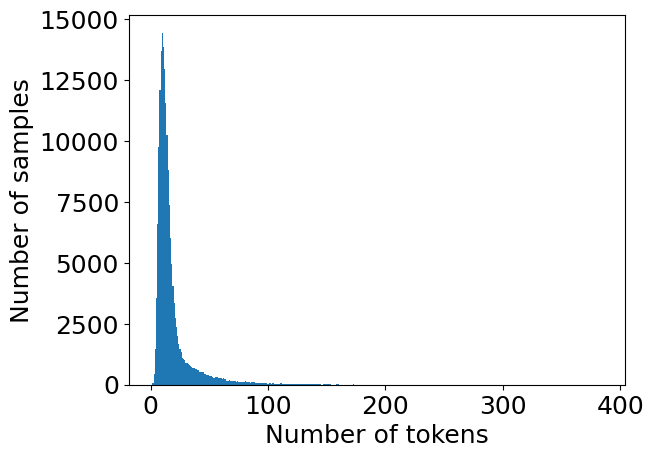

In [84]:
visualize_question_length(datasets["train"])

100%|██████████| 4183/4183 [00:01<00:00, 3302.22it/s]


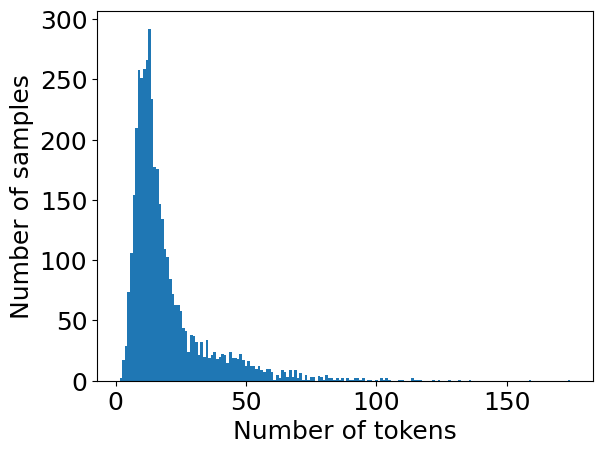

In [85]:
visualize_question_length(datasets["validation"])

In [86]:
from typing import List

def visualize_choice_length(dataset: Dataset, choice_cols: List[str]):
    length_counter = Counter()
    for data in tqdm(dataset):
        for col in choice_cols:
            length = len(tokenizer.tokenize(data[col]))
            length_counter[length] += 1

    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("Number of tokens")
    plt.ylabel("Number of samples")
    plt.show()

100%|██████████| 182822/182822 [01:32<00:00, 1976.12it/s]


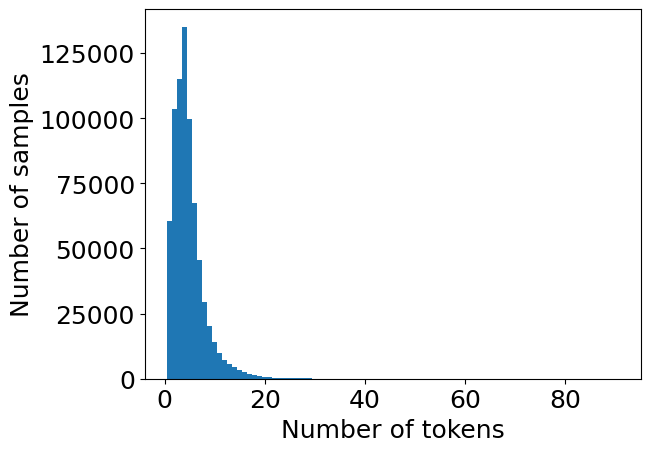

In [87]:
visualize_choice_length(datasets["train"], ['opa', 'opb', 'opc', 'opd'])


100%|██████████| 4183/4183 [00:01<00:00, 2166.32it/s]


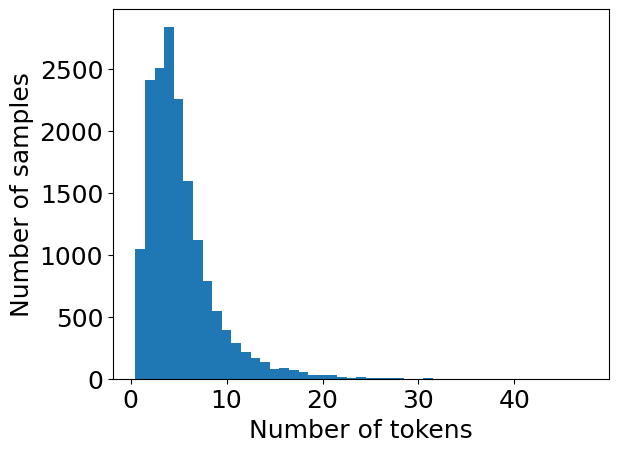

In [88]:
visualize_choice_length(datasets["validation"], ['opa', 'opb', 'opc', 'opd'])


In [89]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [90]:
show_random_elements(datasets["train"])

,id,question,opa,opb,opc,opd,label,choice_type,exp,subject_name,topic_name
0,94a389cc-383c-42c9-b5bb-79351ca45685,Glucose alanine cycle is impoant in:,Liver,Hea,Muscle,Kidney,c,single,"In the fasting state, there is a considerable output of alanine from skeletal muscle, far in excess of its concentration in the muscle proteins that are being catabolized. It is formed by transamination of pyruvate produced by glycolysis of muscle glycogen, and is expoed to the liver, where, after transamination back to pyruvate, it is a substrate for gluconeogenesis. Ref: Harper 28th edition, chapter 20.",Biochemistry,None
1,c92720dc-2475-4f51-bf22-c295ca4ffa54,Which of the following is not a true statement,Vitamin B3 deficiency can manifest as depressive psychosis,Vitamin E deficiency can manifest as spinocerebellar ataxia,Vitamin B2 deficiency can manifest as Burning foot syndrome,Vitamin B6 deficiency can manifest as microcytic anemia,c,multi,Vitamin B5 (Pantothenic acid) deficiency can manifest as Burning foot syndrome (Nutritional melalgia),Biochemistry,None
2,b4a48fd5-d363-4e00-83ad-71727c1a34f6,"In korsakoff psychosis all are seen except -a) Loss of remote memoryb) Loss of intellectual function but preservation of memoryc) Lack of insight, unable to understand the disabilityd) Reversible state",acd,bcd,abc,abd,d,multi,"""Korsakoff syndrome is a mental disorder that is characterized by severe and `irreversible' memory impairment' and confabulation behavior in the absence of intellectual decline or attention deficit"".\n\nRecent memory is impaired with relative preservation of remote memory.\n\n\nLack of insight is a characteristic feature of korsakoff's syndrome.\n\n\nI think there is printing mistake in the question. Except should not be there in the question. In that condition answer will be option 'c'.",Psychiatry,None
3,1f63b2fa-fa8f-40fb-9bd8-ff770760e5ab,All are Bcell markers except,CD 15,CD 19,CD 21,CD 23,a,multi,None,Pathology,None
4,93346b95-89cf-4d6f-9a79-65483788f97a,Poisoning by an irritant may be mistaken for,Peritonitis,Cholera,Gastroenteritis,Intestinal Obstruction,c,single,"Irritants cause symptoms of gastroenteritis eg: abdominal pain, vomiting, purging.",Forensic Medicine,None
5,4b6c33ef-6a53-400c-a535-38fc0c9c3ee3,Contraindication for laparoscopic Cholecystectomy is?,Coagulopathy,Obstructive pulmonary disease,End-stage liver disease,All above,d,multi,"Contraindications to laparoscopic cholecystectomy include Coagulopathy Severe chronic obstructive pulmonary disease End-stage liver disease Congestive heart failure Currently,\nthe major contraindication to completing a laparoscopic cholecystectomy is inability to clearly identify all of the anatomic structures",Surgery,None
6,83914485-a073-4925-96de-90a26fc24c30,Which of the following drug causes least sedation?,Hydroxazine,Phenergan,Chlopheneramine,Loratidine,d,single,"Loratadine is a second-generation tricyclic H1 histamine antagonist which acts as a selective inverse agonist of peripheral histamine H1-receptors. As a ""non-sedating"" antihistamine, loratadine causes less sedation and psychomotor retardation than the older antihistamines because it penetrates the blood brain barrier to a smaller extent. Other possible side-effects include headache and antimuscarinic effects such as urinary retention, dry mouth, blurred vision, and gastrointestinal disturbances.",Pharmacology,None
7,c759b34c-69a0-4f16-b3b2-b7872e38d23b,Smita is a case of infeility. What is the right time in her menstrual cycle to do endometrial biopsy.,12 - l4 days,17 - 19 days,20 - 22 days,3-5days,c,single,"Ans. is c i.e. 20 - 22 days ENDOMETRIAL BIOPSY OPD procedure for hormonal evaluation in case of infeility / DUB/TB. Usually performed in pre - menstrual phase from lateral wall of vagina. Interpretation : Presence of secretory endometrium Progesterone phase (cycles has been ovulatory) Presence of proliferative endometrium Anovulatory cycle Luteal phase defect can also be diagnosed by endometrial biop

In [91]:
def show_one(example):
    print(f"Context: {example['exp']}")
    print(f"  A - {example['question']} {example['opa']}")
    print(f"  B - {example['question']} {example['opb']}")
    print(f"  C - {example['question']} {example['opc']}")
    print(f"  D - {example['question']} {example['opd']}")
    print(f"\nGround truth: option {['A', 'B', 'C', 'D'][example[label_col]]}")

In [92]:
show_one(datasets["train"][0])

Context: Chronic urethral obstruction because of urinary calculi, prostatic hyperophy, tumors, normal pregnancy, tumors, uterine prolapse or functional disorders cause hydronephrosis which by definition is used to describe dilatation of renal pelvis and calculus associated with progressive atrophy of the kidney due to obstruction to the outflow of urine Refer Robbins 7yh/9,1012,9/e. P950
  A - Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma Hyperplasia
  B - Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma Hyperophy
  C - Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma Atrophy
  D - Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma Dyplasia

Ground truth: option C


In [93]:
show_one(datasets["train"][15])

Context: None
  A - With which of the following receptors theophylline has an antagonistic interaction ? Histamine receptors
  B - With which of the following receptors theophylline has an antagonistic interaction ? Bradykinin receptors
  C - With which of the following receptors theophylline has an antagonistic interaction ? Adenosine receptors
  D - With which of the following receptors theophylline has an antagonistic interaction ? Imidazoline receptors

Ground truth: option C


In [94]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [101, 7592, 1010, 2023, 2028, 6251, 999, 102, 1998, 2023, 6251, 3632, 2007, 2009, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [95]:
ending_names = ["opa", "opb", "opc", "opd"]

def preprocess_function(examples):
    # Repeat each first sentence four times to go with the four possibilities of second sentences.
    # first_sentences = [[context] * 4 for context in examples["exp"]]
    # Grab all second sentences possible for each context.
    question_headers = examples["question"]
    second_sentences = [[f"{header} {examples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)]

    # Flatten everything
    # first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    # Tokenize
    tokenized_examples = tokenizer(second_sentences, truncation=True)
    # Un-flatten
    return {k: [v[i:i+4] for i in range(0, len(v), 4)] for k, v in tokenized_examples.items()}

In [96]:
examples = datasets["train"][:5]
features = preprocess_function(examples)
print(len(features["input_ids"]), len(features["input_ids"][0]), [len(x) for x in features["input_ids"][0]])


5 4 [30, 30, 30, 31]


In [99]:
idx = 3
examples = [tokenizer.decode(features["input_ids"][idx][i]) for i in range(4)]
examples[0]


'[CLS] which vitamin is supplied from only animal source : vitamin c [SEP]'

In [100]:
examples

['[CLS] which vitamin is supplied from only animal source : vitamin c [SEP]',
 '[CLS] which vitamin is supplied from only animal source : vitamin b7 [SEP]',
 '[CLS] which vitamin is supplied from only animal source : vitamin b12 [SEP]',
 '[CLS] which vitamin is supplied from only animal source : vitamin d [SEP]']

In [101]:
show_one(datasets["train"][3])

Context: The central aery of the retina is a branch of the ophthalmic aery. It is the sole blood supply to the retina; it has no significant collateral circulation and blockage of this vessel leads to blindness. The branches of this aery are what you view during a fundoscopic exam. Note: The infraorbital aery is a branch of the maxillary aery. It comes through the infraorbital foramen, inferior to the eye. It supplies the maxillary sinus, the maxillary incisors, canine and premolar teeth, and the skin of the cheek below the orbit. The supraorbital aery is another branch of the maxillary aery. It comes through the supraorbital foramen and supplies blood to the muscles, skin and fascia of the forehead. The lacrimal aery is a branch of the ophthalmic aery that supplies the lacrimal gland. The nasociliary aery doesn't exist, but there is a nasociliary nerve that travels with the ophthalmic aery. Ref: Moon D.A., Foreman K.B., Albeine K.H. (2011). Chapter 18. Orbit. In D.A. Moon, K.B. Forema

In [102]:
encoded_datasets = datasets.map(preprocess_function, batched=True)

In [117]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch

@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        pad_token = tokenizer.vocab[tokenizer.pad_token]
        label_name = label_col if label_col in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] + [pad_token] for k, v in feature.items()} for i in range(num_choices)] for feature in features]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(flattened_features,
                                   padding=self.padding,
                                   max_length=self.max_length,
                                   pad_to_multiple_of=self.pad_to_multiple_of,
                                   return_tensors="pt",)

        # Un-flatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}

        # Add back labels
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)

        return batch

In [118]:
accepted_keys = ["input_ids", "attention_mask", label_col]
features = [{k: v for k, v in encoded_datasets["train"][i].items() if k in accepted_keys} for i in range(10)]
batch = DataCollatorForMultipleChoice(tokenizer)(features)
# batch

In [119]:
batch

{'input_ids': tensor([[[  101, 11888, 24471,  ...,     0,     0,     0],
          [  101, 11888, 24471,  ...,     0,     0,     0],
          [  101, 11888, 24471,  ...,     0,     0,     0],
          [  101, 11888, 24471,  ...,     0,     0,     0]],
 
         [[  101,  2029, 17663,  ...,     0,     0,     0],
          [  101,  2029, 17663,  ...,     0,     0,     0],
          [  101,  2029, 17663,  ...,     0,     0,     0],
          [  101,  2029, 17663,  ...,     0,     0,     0]],
 
         [[  101,  2035,  1997,  ...,     0,     0,     0],
          [  101,  2035,  1997,  ...,     0,     0,     0],
          [  101,  2035,  1997,  ...,     0,     0,     0],
          [  101,  2035,  1997,  ...,     0,     0,     0]],
 
         ...,
 
         [[  101,  2566, 28667,  ...,     0,     0,     0],
          [  101,  2566, 28667,  ...,     0,     0,     0],
          [  101,  2566, 28667,  ...,     0,     0,     0],
          [  101,  2566, 28667,  ...,     0,     0,     0]],
 

In [120]:
from transformers import AutoModelForMultipleChoice

model = AutoModelForMultipleChoice.from_pretrained(model_checkpoint)

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [121]:
# from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model

# model = prepare_model_for_kbit_training(model)


In [122]:
# print(model)

In [123]:
# import bitsandbytes as bnb

# def find_all_linear_names(model):
#     cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
#     lora_module_names = set()
#     for name, module in model.named_modules():
#         if isinstance(module, cls):
#             names = name.split('.')
#             lora_module_names.add(names[0] if len(names) == 1 else names[-1])
#         if "lm_head" in lora_module_names: # Needed for 16bit
#             lora_module_names.remove("lm_head")

#     return list(lora_module_names)


In [124]:
# modules = find_all_linear_names(model)
# print(modules)

In [125]:
# from peft import LoraConfig, get_peft_model

# lora_config = LoraConfig(r=16,
#                          lora_alpha=32,
#                          target_modules=modules,
#                          lora_dropout=0.1,
#                          bias="none",
#                          task_type="QUESTION_ANS")

# model = get_peft_model(model, lora_config)

In [126]:
# trainable, total = model.get_nb_trainable_parameters()
# print(f"Trainable: {trainable} | total: {total} | Percentage: {trainable/total*100:.4f}%")

In [127]:
# if torch.cuda.device_count() > 1: # If more than 1 GPU
#     model.is_parallelizable = True
#     model.model_parallel = True

In [128]:
# model(**batch)

In [129]:
[tokenizer.decode(batch["input_ids"][8][i].tolist()) for i in range(4)]

['[CLS] characteristics of remifentanyl – a ) metabolised by plasma esteraseb ) short half lifec ) more potent than alfentanyld ) dose reduced in hepatic and renal diseasee ) duration of action more than alfentanyl ab [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] characteristics of remifentanyl – a ) metabolised by plasma esteraseb ) short half lifec ) more potent than alfentanyld ) dose reduced in hepatic and renal diseasee ) duration of action more than alfentanyl bc [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] characteristics of remifentanyl – a ) metabolised by plasma esteraseb ) short half lifec ) more potent than alfentanyld ) dose reduced in hepatic and renal diseasee ) duration of action more than alfentanyl abc [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] characteristics of remifentanyl – a ) metabolised by plasma esteraseb ) short half lifec ) more p

In [130]:
show_one(datasets["train"][5])

Context: Ans. C i.e. Mite
  A - Scrub typhus is transmitted by: September 2004 Louse
  B - Scrub typhus is transmitted by: September 2004 Tick
  C - Scrub typhus is transmitted by: September 2004 Mite
  D - Scrub typhus is transmitted by: September 2004 Milk

Ground truth: option C


In [131]:
import numpy as np

def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}

In [132]:
from transformers import TrainingArguments

batch_size = 50

# training_args = TrainingArguments(output_dir="bert_mcq",
#                                   per_device_train_batch_size=batch_size,
#                                   per_device_eval_batch_size=batch_size,
#                                   learning_rate=5e-5,
#                                   lr_scheduler_type="linear",
#                                   warmup_ratio=0.1,
#                                   num_train_epochs=3,
#                                   save_strategy="steps",
#                                   logging_strategy="steps",
#                                   load_best_model_at_end=True,
#                                   metric_for_best_model="accuracy",
#                                   save_steps=5,
#                                   eval_steps=5,
#                                   evaluation_strategy="steps",
#                                   fp16=False,
#                                   # bf16=True,
#                                   )

training_args = TrainingArguments(output_dir="bert_mcq",
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  num_train_epochs=3,
                                  weight_decay=0.01,
                                  save_strategy="steps",
                                  logging_strategy="steps",
                                  evaluation_strategy="steps",
                                  save_steps=5,
                                  eval_steps=5,
                                  push_to_hub=True)

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model,
                  tokenizer=tokenizer,
                  args=training_args,
                  train_dataset=encoded_datasets["train"],
                  eval_dataset=encoded_datasets["validation"],
                  data_collator=DataCollatorForMultipleChoice(tokenizer),
                  compute_metrics=compute_metrics,)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

In [ ]:
tokenizer.push_to_hub()
trainer.push_to_hub()

In [ ]:
eval_metrics = trainer.evaluate(encoded_test_dataset)
pprint(eval_metrics)

In [ ]:
from huggingface_hub import login

login()

In [ ]:
tokenizer.push_to_hub(repo_name)
model.push_to_hub(repo_name)